<a href="https://colab.research.google.com/github/Adhithya-Laxman/Image_classification/blob/main/Image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
!pip install wandb

In [44]:
# Task 1 -- Loading the datasets and the packages
from keras.datasets import fashion_mnist
from keras.datasets import mnist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wandb



> Plotting a sample image for each class


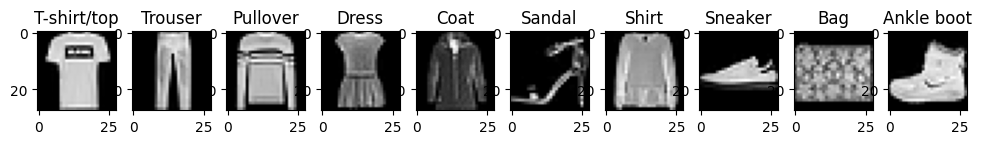

In [45]:
# Loading the dataset:

(X, y),_= fashion_mnist.load_data()
(train_images, train_labels) = (X,y)
# Defining Class Labels:

class_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress",
    "Coat", "Sandal", "Shirt", "Sneaker",
    "Bag", "Ankle boot"
]

# Plotting a sample image for each class:

plt.figure(figsize=(12,12))
for i in range(len(class_labels)):
  # Get the image data matching the current class i
  ind = np.where(train_labels == i)[0][0]
  image  = train_images[ind]
  # plot
  # plt.title("examples")
  plt.subplot(1, len(class_labels), i+1)
  plt.imshow(image,cmap = 'gray')
  plt.title(class_labels[i])
plt.show()

Preprocessing dataset

In [46]:
import numpy as np
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split

def preprocess_fashion_mnist():
    # Load the Fashion-MNIST dataset
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

    # Flatten and normalize the input data
    X_train = X_train.reshape(-1, 28*28)  # Flatten each image to a 1D vector
    X_test = X_test.reshape(-1, 28*28)
    X_train = X_train.astype('float32') / 255.0  # Normalize pixel values to [0, 1]
    X_test = X_test.astype('float32') / 255.0

    # One-hot encode the labels
    num_classes = 10
    y_train = np.eye(num_classes)[y_train]  # One-hot encode the training labels
    y_test = np.eye(num_classes)[y_test]    # One-hot encode the test labels

    # Split the data into training, validation, and test sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=6000, random_state=42)

    # Transpose the data to match the (features, batch_size) format expected by the function
    X_train = X_train.T
    X_val = X_val.T
    X_test = X_test.T
    # print(type(X_train))
    # Print the number of images in X and y for training, validation, and testing datasets
    print("Number of images in the training set =", X_train.shape[1])
    print("Number of images in the validation set =", X_val.shape[1])
    print("Number of images in the test set =", X_test.shape[1])
    print("Number of classes =", num_classes)
    print("Number of features per example =", X_train.shape[0])

    return X_train, y_train, X_val, y_val, X_test, y_test

# Preprocess the Fashion-MNIST dataset
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_fashion_mnist()


Number of images in the training set = 54000
Number of images in the validation set = 6000
Number of images in the test set = 10000
Number of classes = 10
Number of features per example = 784


IMPLEMENTATION OF FEEDFORWARD NEURAL NETWORK:<br>
It takes the images from the fashion-mnist data as input and outputs a probability distribution over the 10 classes.

ACTIVATION FUNCTION AND DERIVATIVES

In [47]:
def sigmoid(x):
    return 1. / (1.+np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1-sigmoid(x))

def relu(x):
    return np.maximum(0,x)

def relu_derivative(x):
    return 1*(x>0)

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return (1 - (np.tanh(x)**2))

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def softmax_derivative(x):
    return softmax(x) * (1-softmax(x))

Initializing parameters

In [48]:
import numpy as np

# Initialize parameters
def initialize_parameters(layer_sizes, mode='xavier'):
  np.random.seed(42)
  parameters = {}
  for i in range(1, len(layer_sizes)):
    if mode == "xavier" :
      parameters["W" + str(i)] = np.random.randn(layer_sizes[i], layer_sizes[i-1])*np.sqrt(2./(layer_sizes[i] + layer_sizes[i-1]))
      parameters["b" + str(i)] = np.zeros((layer_sizes[i],1))
    elif mode == "random" :
      parameters["W" + str(i)] = 0.01*np.random.randn(layer_sizes[i], layer_sizes[i-1])
      parameters["b" + str(i)] = 0.01*np.random.randn(layer_sizes[i],1)

  return parameters

def update_init(sizes) :                                  # function to initialize update dictionary that changes the weights and biases
  update = {}
  for i in range(1,len(sizes)):
   update["W"+str(i)] = np.zeros((sizes[i],sizes[i-1]))
   update["b"+str(i)] = np.zeros((sizes[i],1))

  return update

def update_parameters(parameters, gradients, learning_rate):
    L = len(parameters) // 2
    for l in range(1, L + 1):
        parameters[f"W{l}"] -= learning_rate * gradients[f"dW{l}"]
        parameters[f"b{l}"] -= learning_rate * gradients[f"db{l}"]

    return parameters

def compute_loss(Y, y_hat, loss_type):
    loss = -1
    if loss_type == 'squared_error':
        loss = np.mean(np.square(Y - y_hat)) / 2
    elif loss_type == 'cross_entropy':
        y_hat = y_hat.T  # Transpose y_hat to match the shape of Y

        loss = -np.mean(np.multiply(Y,np.log(y_hat)))
    return loss


FEED FORWARD NEURAL NETWORK:

Forward Propagation


In [49]:
def forward_propagation(X, params, layer_sizes, mode):
    A = {}
    H = {}
    # Z = A, A = H
    L = len(layer_sizes)
    H[0] = X  # Initialize input data as A[0]
    for k in range(1, L):
        W = params["W" + str(k)]
        b = params["b" + str(k)]
        A[k] = b + np.dot(W, H[k - 1])
        if mode == 'sigmoid':
            H[k] = sigmoid(A[k])
        elif mode == 'tanh':
            H[k] = tanh(A[k])
        elif mode == 'relu':
            H[k] = relu(A[k])
    W = params["W" + str(L-1)]
    b = params["b" + str(L-1)]
    A[L-1] = b + np.dot(W, H[L - 2])
    y_hat = softmax(A[L-1])
    return y_hat, H, A


Backward Propagation

In [50]:
def derivative(x, mode):
  if mode == 'sigmoid':
    return sigmoid_derivative(x)
  elif mode == 'tanh':
    return tanh_derivative(x)
  elif mode == 'relu':
    return relu_derivative(x)
  return None
def backward_propagation(X, Y, H, A, y_hat, params,layer_sizes, mode, loss_type):
    L = len(layer_sizes)
    gradients = {}
    y_hat = y_hat.T  # Transpose y_hat to match the shape of Y

    if loss_type == "squared_error":
        gradients[f"dH{L - 1}"] = (y_hat - Y)
        gradients[f"dA{L - 1}"] = (y_hat - Y) * y_hat - y_hat * (np.dot(np.transpose((y_hat - Y)), y_hat))
        # gradients["dZ"+str(L)] = (A[L]-y) * softmax_derivative(Z[L])

    elif loss_type == "cross_entropy":
      # Dark green top part == grad(dH[L-1]) = (-1/y_hat) * (e(l))
      # e(l) -- One hot encoder -- equal to 1 only for the l'th entry, all others are zero. Here one hot encode = Y
        gradients[f"dH{L - 1}"] = -(Y / y_hat)
      # Light green part of output function grad(dA[L-1]) = -(e(l) - y_hat). here e(l) = Y
        gradients[f"dA{L - 1}"] = -(Y - y_hat)
    # NOW WE HAVE FOR THE ENTIRE OUTPUT UNITS


    for i in range(1, L):  # Updated the range to include the output layer
        gradients[f"dW{i}"] = np.zeros((layer_sizes[i], layer_sizes[i - 1]))
        gradients[f"db{i}"] = np.zeros((layer_sizes[i], 1))
        gradients[f"dA{i}"] = np.zeros((layer_sizes[i], 1))
        gradients[f"dH{i}"] = np.zeros((layer_sizes[i], 1))

    for k in range(L-1, 0, -1):

        # grad(W{k}) = matrix_multiplication(grad(A{k}) , H[k-1].Transpose)
        print(gradients[f"dA{k}"])
        print(np.transpose(H[k - 1]))
        gradients[f"dW{k}"] = np.matmul(gradients[f"dA{k}"], np.transpose(H[k - 1]))
        gradients[f"db{k}"] = gradients[f"dA{k}"]

        if k > 1:
          # For the hidden layers
          # grad(dh{i})  = ((W{i+1})T) . (grad(A{i+1}))
            gradients[f"dH{k - 1}"] = np.dot(np.transpose(params[f"W{k}"]), gradients[f"dA{k}"])

          # grad(da{i}) = grad{h} (.) g'(a{ik})
          # (.) -- element wise multiplpication , g' -- deivative
            gradients[f"dA{k - 1}"] = np.multiply(gradients[f"dH{k-1}"], derivative(A[k - 1], mode))

    return gradients


In [51]:
def train(X, Y, layer_sizes, mode='xavier', activation='relu', loss_type='cross_entropy', num_epochs=100, learning_rate=0.1):
    parameters = initialize_parameters(layer_sizes, mode)
    train_loss_history = []
    for epoch in range(num_epochs):
        # Forward propagation
        y_hat, H, A = forward_propagation(X, parameters, layer_sizes, activation)

        # Compute loss
        loss = compute_loss(Y, y_hat, loss_type)
        train_loss_history.append(loss)

        # Backward propagation
        gradients = backward_propagation(X, Y, H, A, y_hat, parameters,layer_sizes, activation, loss_type)

        # Update parameters
        parameters = update_parameters(parameters, gradients, learning_rate)

        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss}")

    return parameters, train_loss_history


In [52]:
def predict(X, parameters,layer_sizes , activation):
  y_hat, _  ,__ = forward_propagation(X,parameters,layer_sizes, activation)
  return y_hat

In [53]:

# # Define the neural network architecture

# # Input layer (784 features), 2 hidden layers (128 and 64 neurons), Output layer (10 classes)
# layer_sizes = [784, 128,32,64,10]
# parameters, train_loss_history = train(X_train, y_train, layer_sizes, mode='xavier', activation='relu', loss_type='cross_entropy', num_epochs=5, learning_rate=0.1)

# # Make predictions on the test set
# y_pred = predict(X_test, parameters, layer_sizes,activation='relu')

# # Calculate accuracy on the test set
# accuracy = np.mean(np.argmax(y_pred, axis=0) == np.argmax(y_test, axis=1))
# print("Test Accuracy:", accuracy)



In [54]:
def val_loss(y,y_hat,loss_type):                                # function to compute the loss/error (both squared error and cross entropy)
  l = 0
  if (loss_type == "squared_error"):
    l = np.sum((y-y_hat)**2)/(2*len(y))
  elif (loss_type == "cross_entropy") :
    l = -1*np.sum(np.multiply(y,np.log(y_hat)))/len(y)
  return l

def calcAccLoss(parameters,xArr,yArr,sizes,loss_type,activation,type="val",regu=None):          #function to calculate accuracy and total loss of a model
  acc=0.0
  lossVal=0.0
  for x,y in zip(xArr,yArr):
    y_hat= feed_forward(x,parameters,sizes,activation)[0]
    if y_hat.argmax()==y.argmax():
      acc+=1
    if type=="val":
      lossVal+=val_loss(y,y_hat,loss_type)
    elif type=="trng":
      lossVal+=loss_compute(y,y_hat,parameters,loss_type,regu,sizes)
  acc=acc/len(xArr)
  return (acc,lossVal)

Optimized GD's

In [57]:
# Momentum GD

def update_init(sizes) :                                  # function to initialize update dictionary that changes the weights and biases
  update = {}
  for i in range(1,len(sizes)):
   update["W"+str(i)] = np.zeros((sizes[i],sizes[i-1]))
   update["b"+str(i)] = np.zeros((sizes[i],1))

  return update
def grad_init(sizes):

  grads={}
  layers=len(sizes)
  for i in range(1,layers):
    grads["dW" + str(i)] = np.zeros((sizes[i], sizes[i-1]))
    grads["db" + str(i)] = np.zeros((sizes[i],1))

  return grads

def momentum_GD(X, Y, layer_sizes, mode='xavier', activation='relu', loss_type='cross_entropy', num_epochs=100, learning_rate=0.1, mini_batch = 1):
    steps = 0
    parameters = initialize_parameters(layer_sizes, mode)
    train_loss_history = []
    update = update_init(layer_sizes)
    for epoch in range(num_epochs):
      for j in range(0 , X.shape(0), mini_batch):
        X_mini = X[j:j+mini_batch]
        Y_mini = Y[j:j++mini_batch]
        grads = grad_init(layer_sizes)

        for x,y in zip(X_mini, Y_mini):
          # Forward propagation
          y_hat, H, A = forward_propagation(x, parameters, layer_sizes, activation)
          # Backward propagation
          gradients = backward_propagation(X, Y, H, A, y_hat, parameters,layer_sizes, activation, loss_type)

        for i in range(len(layer_sizes)):
          update["W"+str(i)] = gamma*update["W"+str(i)] + lr*grads["dW"+str(i)]
          update["b"+str(i)] = gamma*update["b"+str(i)] + lr*grads["db"+str(i)]
          parameters["W"+str(i)] = (1-lr*reg)*parameters["W"+str(i)] - update["W"+str(i)]
          parameters["b"+str(i)] = (1-lr*reg)*parameters["b"+str(i)] - update["b"+str(i)]

        # Update parameters
        parameters = update_parameters(parameters, gradients, learning_rate)

        steps=steps+1
        if steps==10000:                                                                         #log every 10000 updates
          acc,lossTot=calcAccLoss(parameters,X_train,Y_train,sizes,loss_type,activation,type="trng",regu=reg)          #calculating accuracy and loss
          accVal,lossTotVal=calcAccLoss(parameters,X_val,Y_val,sizes,loss_type,activation)

          wandb.log({"Accuracy":acc,"Loss":lossTot,"Accuracy_val":accVal,"Loss_val":lossTotVal,"Epoch":n,"n_datatrain":j + minibatch_size+n*54000}) #logging
          steps=0

    return parameters

Execution -- Main Function
  

In [58]:
#function to select optimizer
def do_GD(X_train,Y_train,optimizer,activation,hl_size,input_size,output_size,n_epoch,lr,reg,w_init,loss_type,minibatch_size=1,logging=False):
  sizes = hl_size.copy()
  sizes.insert(0,input_size)
  sizes.append(output_size)

  if optimizer=="sgd":
    return(stochastic_GD(X_train,Y_train,activation,n_epoch,sizes,lr,reg,w_init,loss_type,minibatch_size=1,log=logging))
  elif optimizer=="momentum":
    return(momentum_GD(X_train,Y_train,activation,n_epoch,sizes,lr,reg,w_init,loss_type,minibatch_size=1,log=logging))
  elif optimizer=="nesterov":
    return(nesterov_accelerated_GD(X_train,Y_train,activation,n_epoch,sizes,lr,reg,w_init,loss_type,minibatch_size=1,log=logging))
  elif optimizer=="rmsprop":
    return(rmsprop_GD(X_train,Y_train,activation,n_epoch,sizes,lr,reg,w_init,loss_type,minibatch_size=1,log=logging))
  elif optimizer=="adam":
    return(adam_GD(X_train,Y_train,activation,n_epoch,sizes,lr,reg,w_init,loss_type,minibatch_size=1,log=logging))
  elif optimizer=="nadam":
    return(nadam_GD(X_train,Y_train,activation,n_epoch,sizes,lr,reg,w_init,loss_type,minibatch_size=1,log=logging))


In [65]:
#training function to sweep with wandb
def train():

  hyperparameter_defaults=dict(
      input_size = 784,
      output_size = 10,
      n_epoch = 5,
      n_hiddenlayer = 3,
      hl= [64,64,64],
      reg = 0.0005,
      lr = 1e-3,
      optimizer = "momentum",
      batch_size = 64,
      initialization = "xavier",
      loss_type = "cross_entropy"

  )

  wandb.init(config=hyperparameter_defaults)

  config=wandb.config
  output_size=10
  input_size = 784
  config.hl=[config.hl_size for i in range(config.n_hiddenlayer)]   #hidden layer sizes array creation
  parameters=do_GD(X, y,config.optimizer,config.activation,config.hl,config.input_size,config.output_size,config.n_epoch,config.lr,config.reg,config.initialization,config.loss_type,config.batch_size,logging=True)


In [60]:
def sweeper(sweep_config,proj_name):
  sweep_id=wandb.sweep(sweep_config,project=proj_name)
  wandb.agent(sweep_id,train,project=proj_name)

In [61]:
#sweep dictionary
sweep_config={
    'method':'bayes',
    'metric':{
        'name':'accuracy',
        'goal':'maximize'},

}

parameters_dict={
    'optimizer':{
        'values':['nadam','sgd', 'momentum', 'nesterov', 'rmsprop', 'adam']
    },
    'lr':{
        'values':[1e-3,1e-5]
    },
    'reg':{
        'values':[5e-4,0,5e-1]
    },
    'n_hiddenlayer':{
        'values':[3,4,5]
    },
    'hl_size':{
      'values':[128,32,64]
    },
    'batch_size':{
        'values':[64,32,128]
    },
    'loss_type':{
        'values':['cross_entropy','squared_error']
    },
    'initialization':{
        'values':['xavier','random']
    },
    'activation':{
        'values':['relu','sigmoid','tanh']
    },
    'n_epoch':{
        'values':[5]
    }
}

sweep_config['parameters']=parameters_dict

In [63]:
proj_name = "Image_classification"
sweep_id=wandb.sweep(sweep_config,project=proj_name)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: 4avpa0rh
Sweep URL: https://wandb.ai/adhithyarg26/Image_classification/sweeps/4avpa0rh


In [64]:
sweeper(sweep_config,proj_name)

Create sweep with ID: np4tcj0w
Sweep URL: https://wandb.ai/adhithyarg26/Image_classification/sweeps/np4tcj0w


wandb: Agent Starting Run: jifnikml with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5
wandb: Currently logged in as: adhithyarg26. Use `wandb login --relogin` to force relogin


Run jifnikml errored: NameError("name 'Y_train' is not defined")
wandb: ERROR Run jifnikml errored: NameError("name 'Y_train' is not defined")
wandb: Agent Starting Run: drjm8xau with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


Run drjm8xau errored: NameError("name 'Y_train' is not defined")
wandb: ERROR Run drjm8xau errored: NameError("name 'Y_train' is not defined")
wandb: Agent Starting Run: etucb0m7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


Run etucb0m7 errored: NameError("name 'Y_train' is not defined")
wandb: ERROR Run etucb0m7 errored: NameError("name 'Y_train' is not defined")
Detected 3 failed runs in the first 60 seconds, killing sweep.
wandb: ERROR Detected 3 failed runs in the first 60 seconds, killing sweep.
wandb: To disable this check set WANDB_AGENT_DISABLE_FLAPPING=true
